# Обработка изображений

Импортируем требуемые библиотеки

In [1]:
from PIL import Image, ImageDraw
import cv2
import numpy as np
from numpy import histogram, std
import math
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import os
import scipy.stats as stats
import sys
import pylab

Загружаем изображение и переписываем его в новую переменную

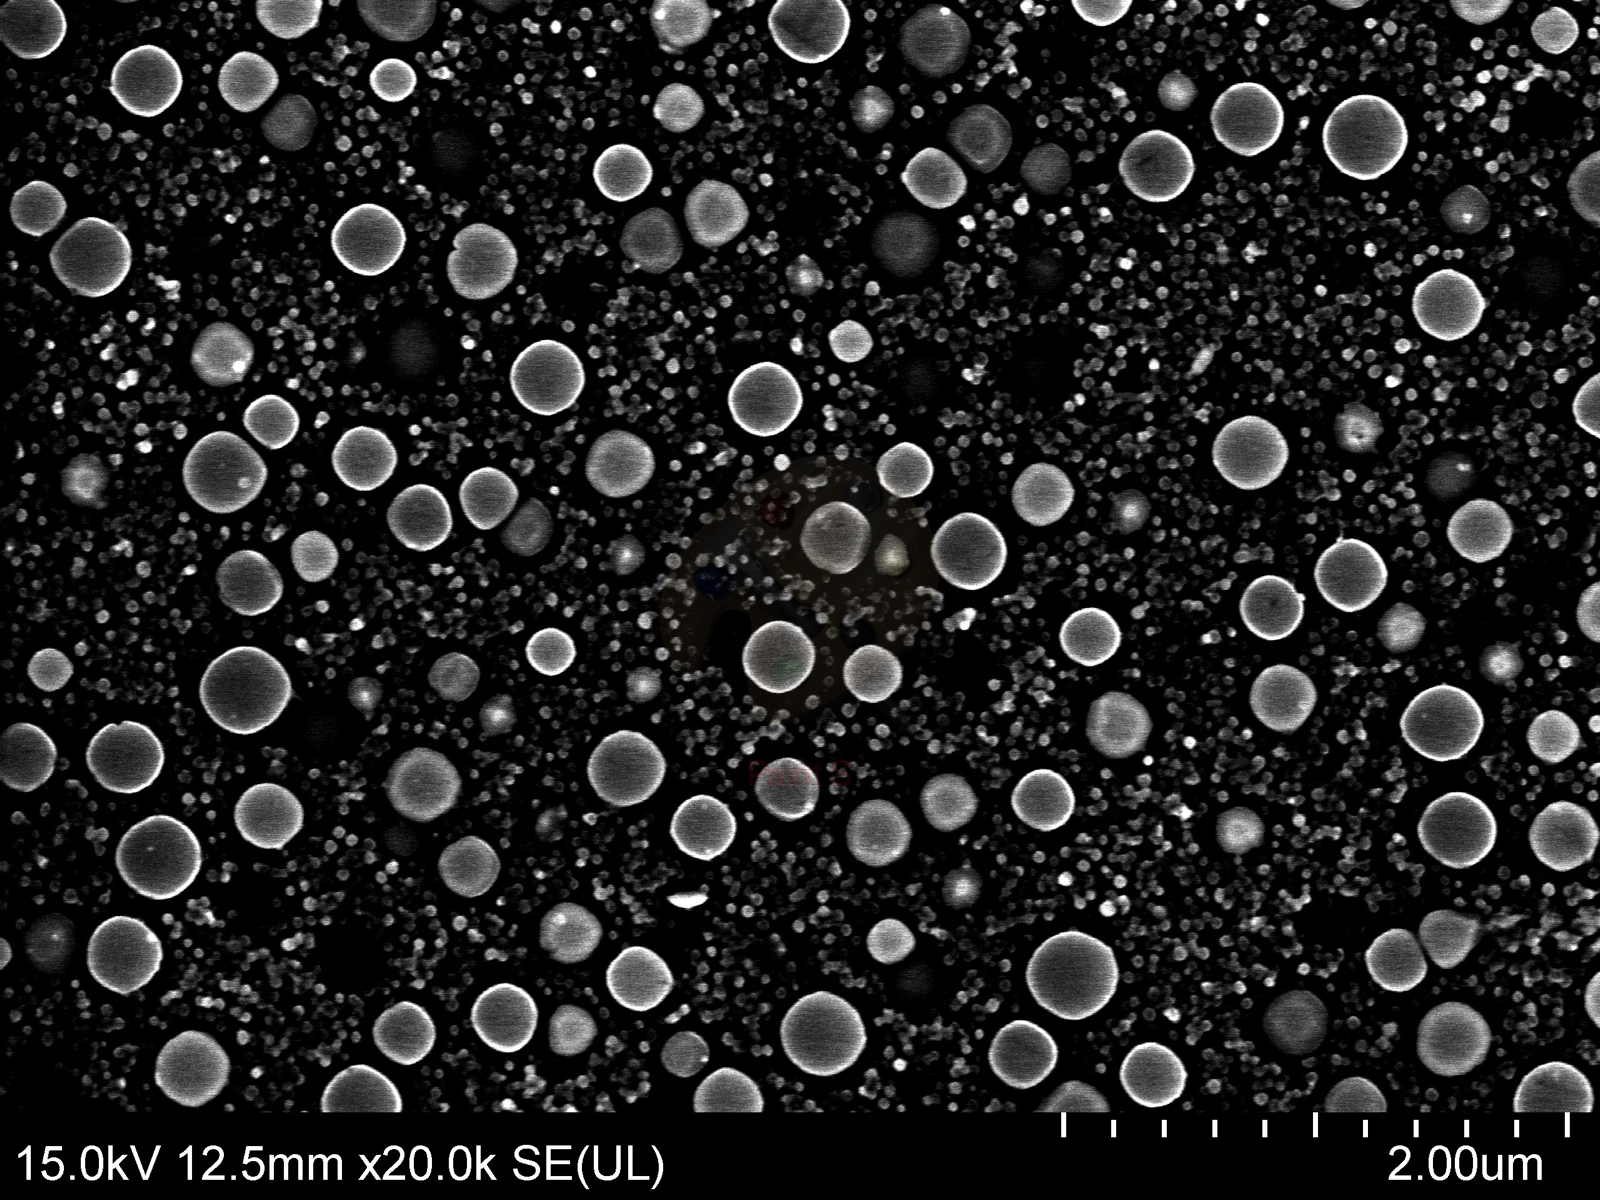

In [2]:
original = '698 фаза.jpg'
image = Image.open(original)
image

Обрезаем исследуемую часть изображения

In [3]:
if image.size == (1600, 1200):
    try:
        area = (0, 0, 1600, 1115)
        image_cut = image.crop(area)
        image_cut.save('698_crop_test.jpg', 'JPEG')
    except:
        print('Необходи изменить разрешение изображения на 1600х1200')

Приступаем к графической обработке изображения с применением пакета OpenCV
    - читаем изображение

In [4]:
image_test = cv2.imread('698_crop_test.jpg', cv2.CV_8UC1)

Определяем цветовую модель изображения и переводим в GrayScale (дописать)

Добавляем небольшое размытие, чтобы при бинаризации убрать шумы

In [5]:
image_blurred = cv2.blur(image_test, (10,10), 0)

Производим непосредственную бинаризацию изображения

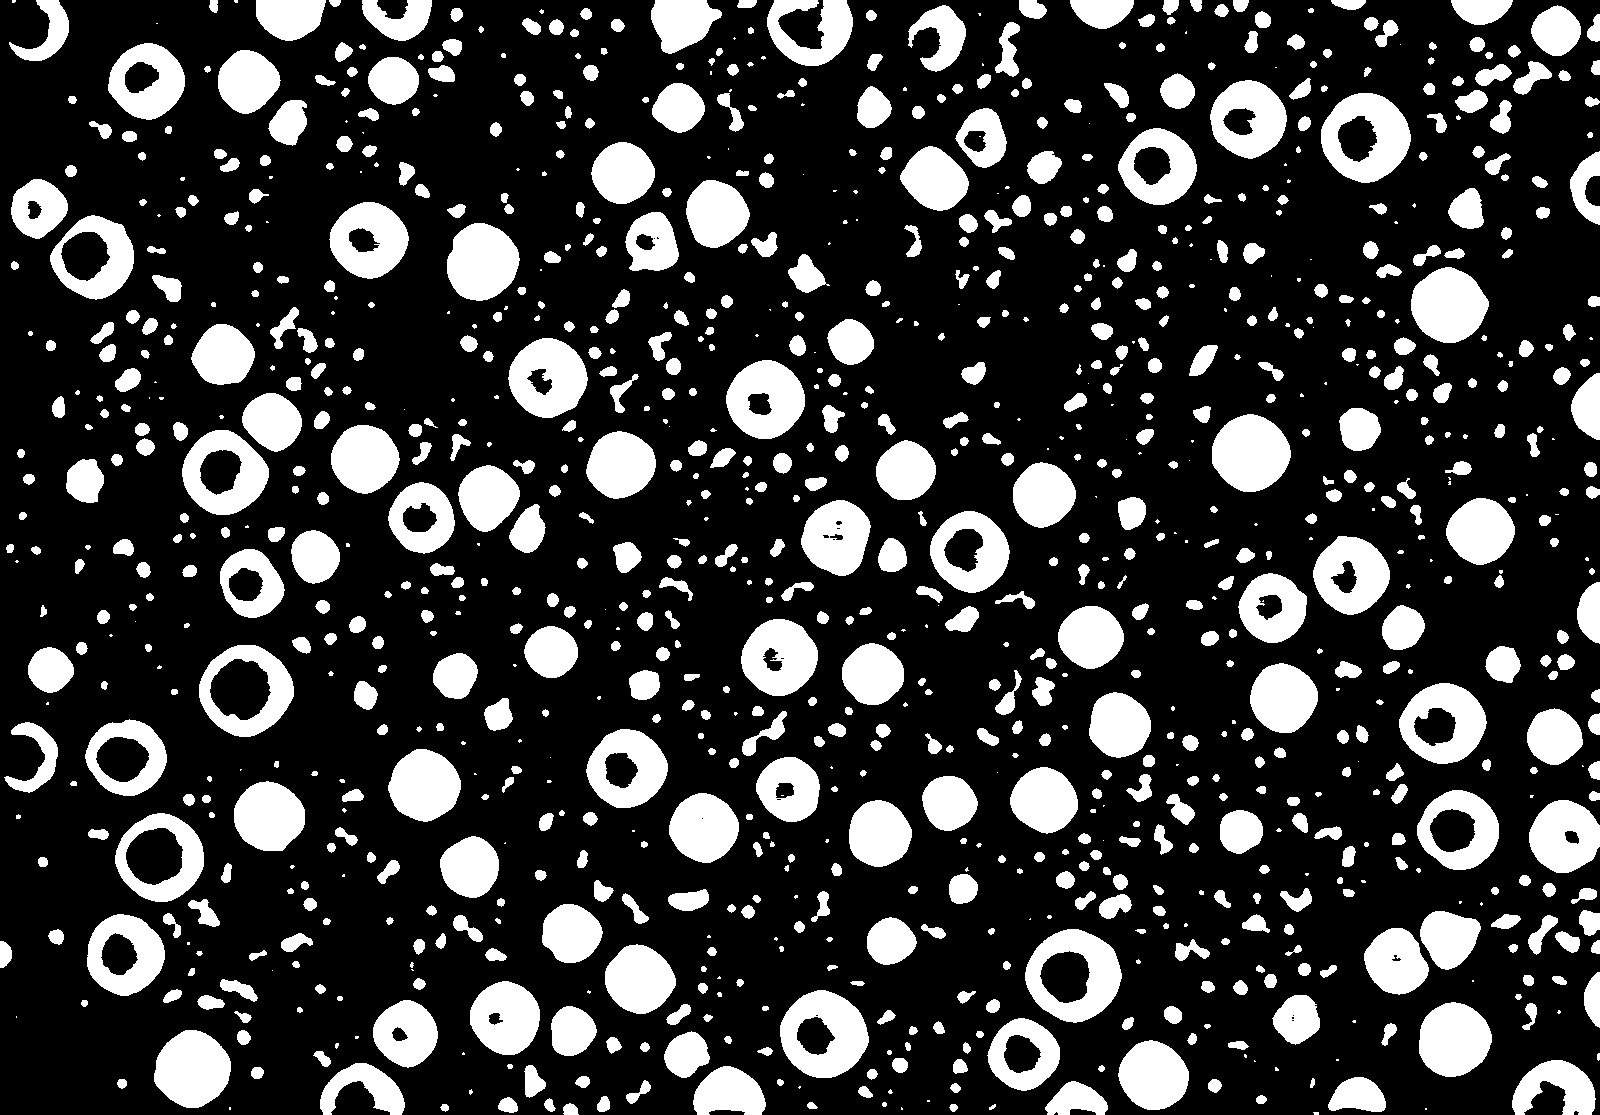

In [6]:
(_, image_binary) = cv2.threshold(image_blurred, 60, 255, cv2.THRESH_BINARY)
cv2.imwrite('wb698.jpg', image_binary)
image1 = Image.open('wb698.jpg')
image1

Определяем "графические" границы 

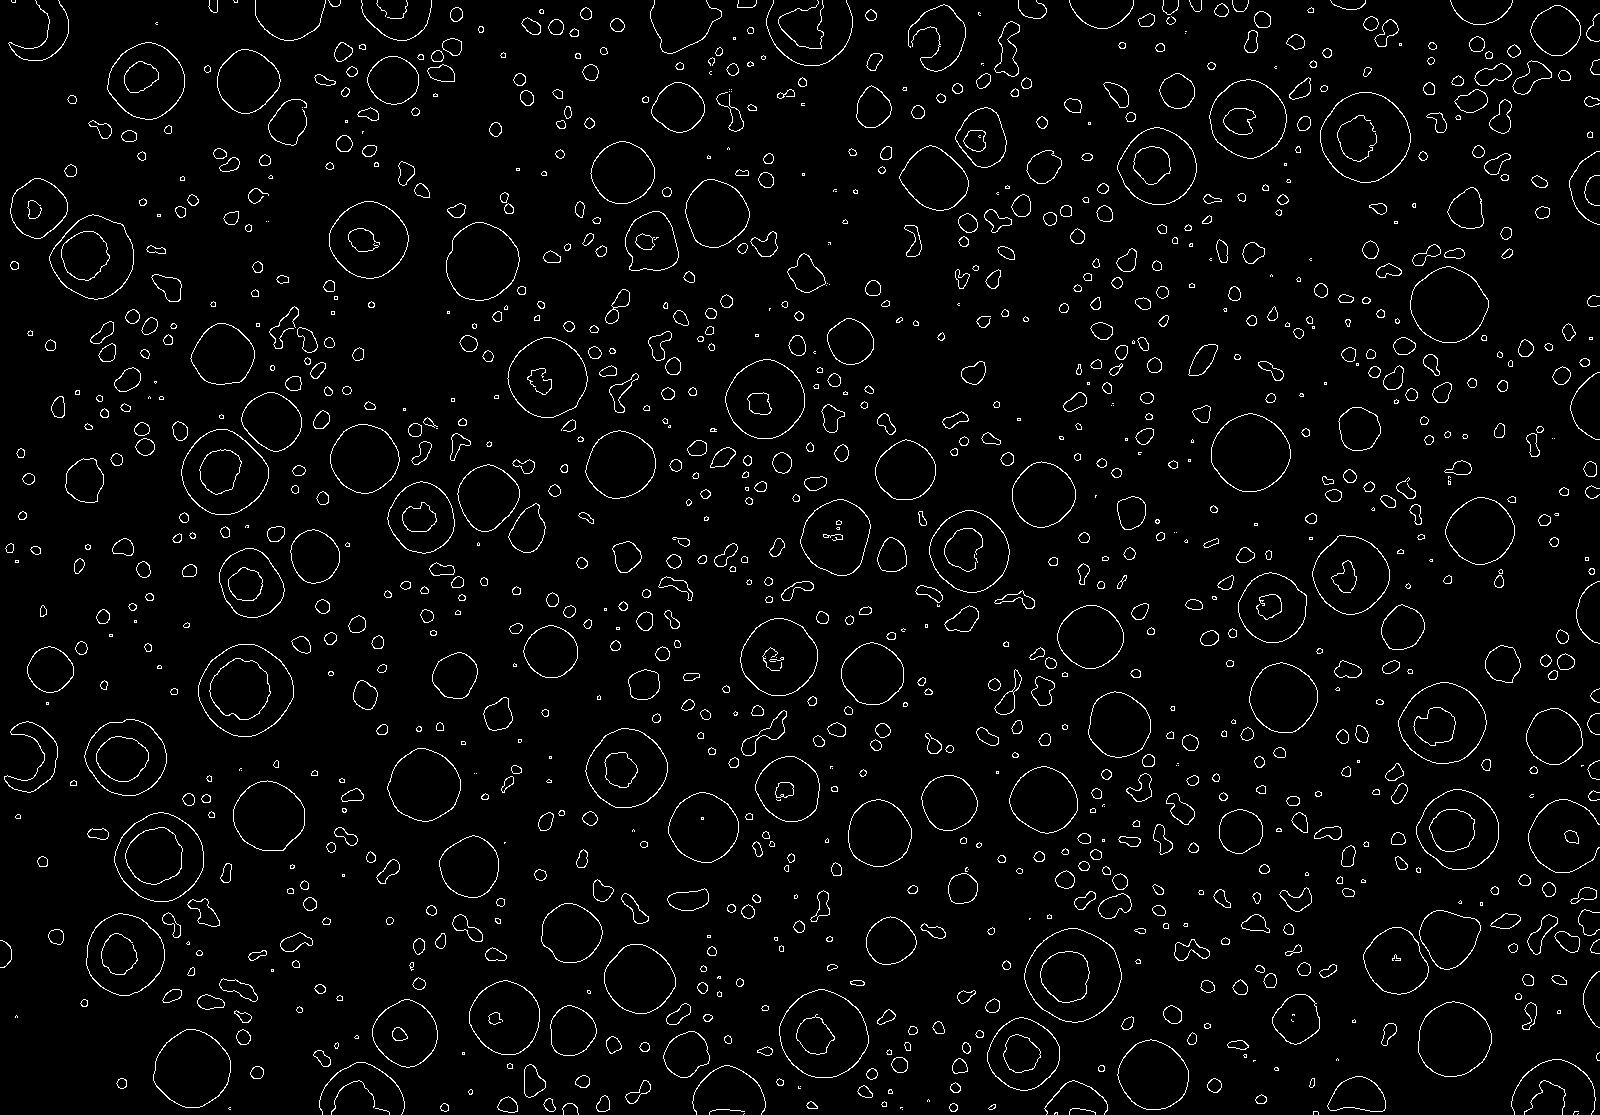

In [7]:
image_canny = cv2.Canny(image_binary, 100, 300)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
image_canny_closed = cv2.morphologyEx(image_canny, cv2.MORPH_CLOSE, kernel)
cv2.imwrite('698_canny_2test.jpg', image_canny_closed)
image1 = Image.open('698_canny_2test.jpg')
image1

Переводим "графические" контуры в "математические", проще говоря - создаем массив NumPy из пикселей каждого контура

In [8]:
contours, hierarchy = cv2.findContours(image_canny_closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

Наносим контуры на исходное изображение



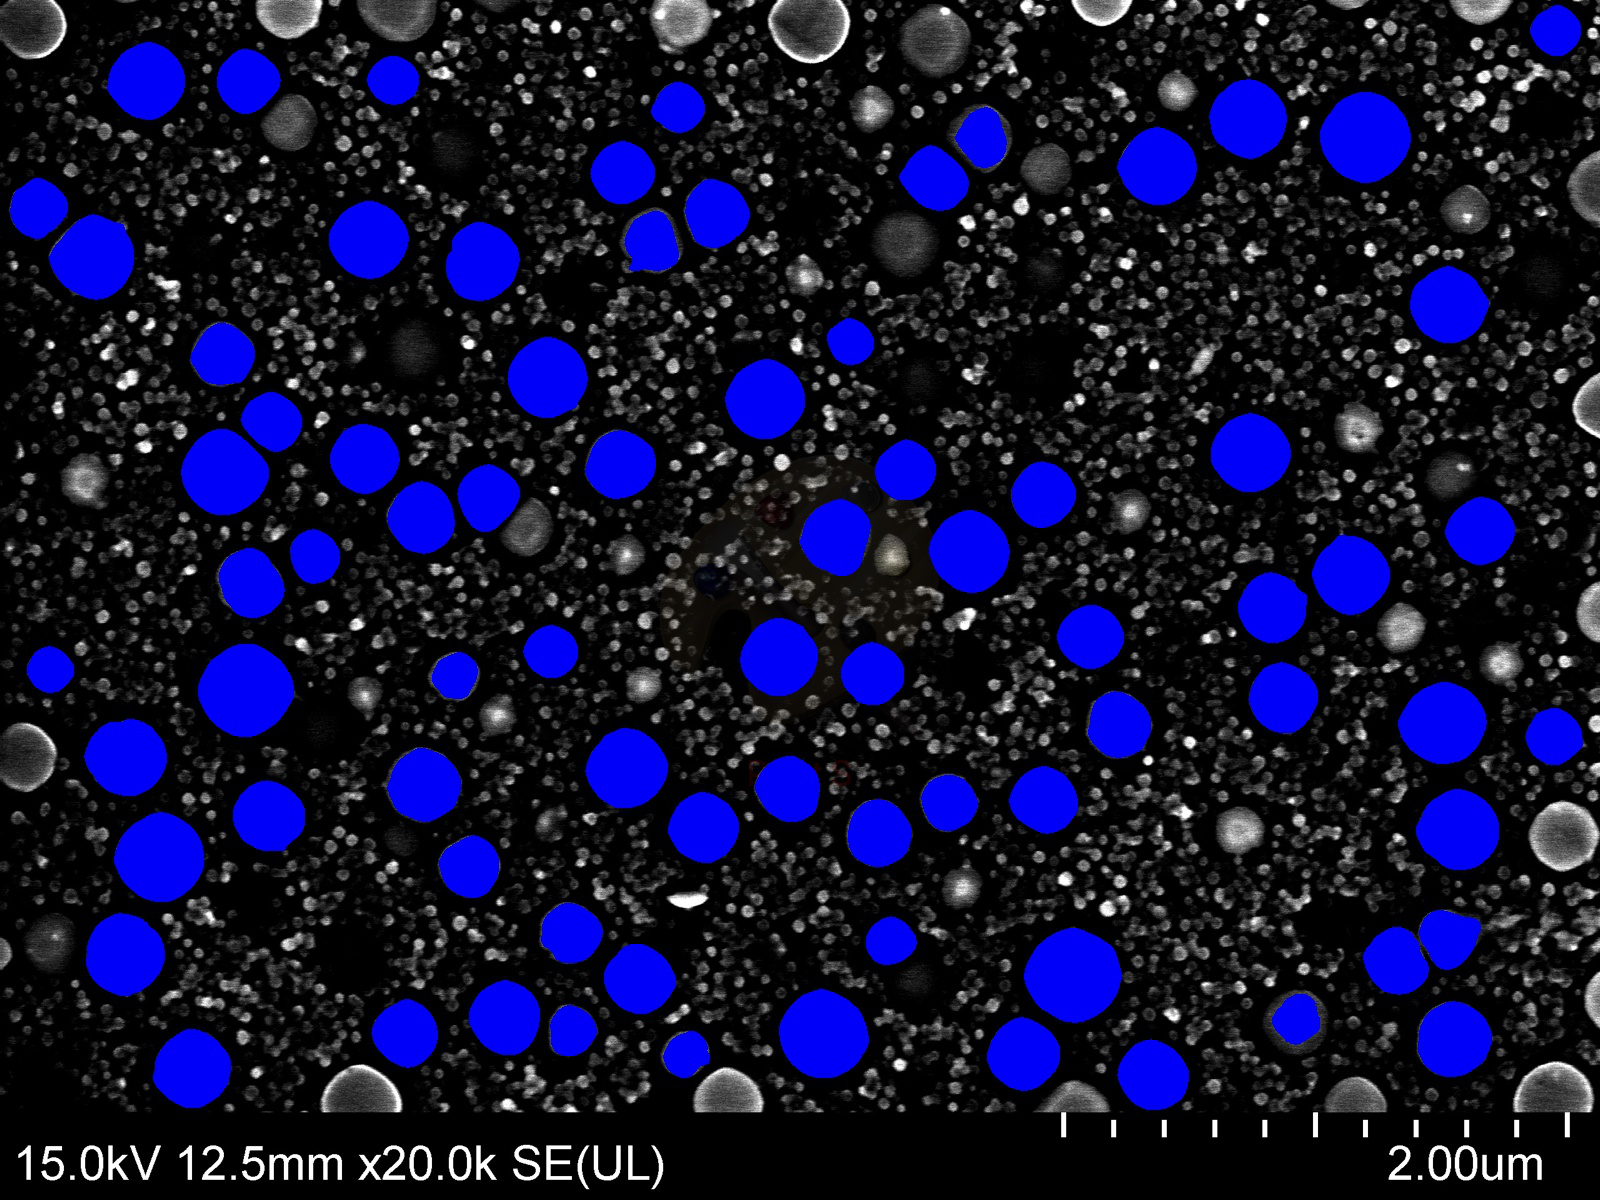

In [9]:
image_original = cv2.imread('698 фаза.jpg', cv2.CV_32FC1)
# color_img = cv2.cvtColor(image_original, cv2.CV_GRAY2RGB)

for contour in contours:
    if cv2.contourArea(contour) > 1500:
        cv2.drawContours(image_original, [contour], -1, (250,0,0), -1)
cv2.imwrite('698_final.jpg', image_original)
image2 = Image.open('698_final.jpg')
image2

# Начинаем математику
 - отсортируем "лишние" мелкие контуры по площади, остальные перепишем в новый список

In [11]:
contour_in_nano = []
for contour in contours: 
    if 1500 <= cv2.contourArea(contour):
        a = cv2.contourArea(contour)
        contour_in_nano.append(a)

Переведем пиксели в нанометры (1:4), а таже из площади получим диаметр каждой частички (пока по формуле для круга)

In [12]:
scale = 4
for i in range(len(contour_in_nano)):
        contour_in_nano[i] = int((math.sqrt((contour_in_nano[i]*4)/(math.pi)))*scale)

Найдем средний размер (диаметр) частички

In [13]:
medium_phase_size = (sum(contour_in_nano))/(len(contour_in_nano))
print('Средний диаметр - ', '%.2f' %medium_phase_size, 'нм, ', 'количество исследованных частиц - ', len(contour_in_nano))

Средний диаметр -  265.03 нм,  количество исследованных частиц -  78


Теперь графически покажем распределение частиц по размеру. Построим график равномерного распределения и совместив с графиком нормального (гаусова) распределения

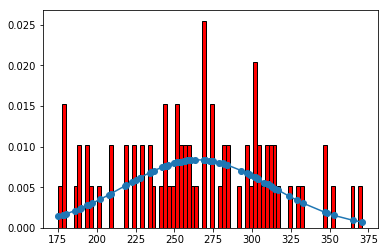

In [15]:
sorted_contour_in_nano = sorted(contour_in_nano)
mu = medium_phase_size
sigma = std(contour_in_nano)
gaus = stats.norm.pdf(sorted_contour_in_nano, mu, sigma)
plt.plot(sorted_contour_in_nano, gaus, '-o')
plt.hist(contour_in_nano, bins=78, normed=True, facecolor='red', edgecolor='black')
plt.show()